# POP MOC(sig2) for 1-degree
 - Compute MOC(sig2) offline from POP history files

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import cf_xarray
import matplotlib.pyplot as plt
%matplotlib inline

from MOCutils import popmoc

### Read in OGCM history file & MOC template file

In [2]:
fpop = '/glade/scratch/yeager/POP_MOC/g210.GIAF_JRA.v14.gx1v7.02.pop.h.0157-01.nc'
ds = xr.open_dataset(fpop)
fmoc = '/glade/u/home/yeager/analysis/python/POP_MOC/moc_template.nc'
ds_moctemp = xr.open_dataset(fmoc)

### Compute sigma-2 field from POP model output

In [3]:
# Get model T & S
salt = ds['SALT']
temp = ds['TEMP']

In [4]:
# Define k-index array
dims = np.shape(temp)
nt = dims[0]
nz = dims[1]
ny = dims[2]
nx = dims[3]
kji = np.indices((nz,ny,nx))
kindices = kji[0,:,:,:] + 1

In [5]:
import pop_tools
refz = 2000
refdep = xr.full_like(salt,refz).rename('REFDEP')

# Sigma2 on model TLAT, TLONG
sigma2_T = pop_tools.eos(salt=salt,temp=temp,depth=refdep) - 1000
sigma2_T = sigma2_T.assign_attrs({'long_name':'Sigma referenced to {}m'.format(refz),'units':'kg/m^3'})
# apply T-grid mask
#mask=kindices<=ds['KMT'].values[None,:,:]
#sigma2_T = sigma2_T.where(mask)

### Define target sigma-2 vertical grid

In [6]:
# Use predefined 86-layer sigma2 grid:
sigma_mid,sigma_edge = popmoc.sigma2_grid_86L()

In [7]:
sigma_mid

<xarray.DataArray (sigma: 86)>
array([28.  , 28.2 , 28.4 , 28.6 , 28.8 , 29.  , 29.2 , 29.4 , 29.6 ,
       29.8 , 30.  , 30.2 , 30.4 , 30.6 , 30.8 , 31.  , 31.2 , 31.4 ,
       31.6 , 31.8 , 32.  , 32.2 , 32.4 , 32.6 , 32.8 , 33.  , 33.2 ,
       33.4 , 33.6 , 33.8 , 34.  , 34.2 , 34.4 , 34.6 , 34.8 , 35.  ,
       35.1 , 35.2 , 35.3 , 35.4 , 35.5 , 35.6 , 35.7 , 35.8 , 35.9 ,
       36.  , 36.05, 36.1 , 36.15, 36.2 , 36.25, 36.3 , 36.35, 36.4 ,
       36.45, 36.5 , 36.55, 36.6 , 36.65, 36.7 , 36.75, 36.8 , 36.85,
       36.9 , 36.95, 37.  , 37.05, 37.1 , 37.15, 37.2 , 37.25, 37.3 ,
       37.35, 37.4 , 37.45, 37.5 , 37.55, 37.6 , 37.65, 37.7 , 37.75,
       37.8 , 37.85, 37.9 , 37.95, 38.  ])
Coordinates:
  * sigma    (sigma) float64 28.0 28.2 28.4 28.6 28.8 ... 37.85 37.9 37.95 38.0
Attributes:
    long_name:  Sigma2 at middle of layer
    units:      kg/m^3

In [8]:
sigma_edge

<xarray.DataArray (sigma: 87)>
array([ 0.   , 28.1  , 28.3  , 28.5  , 28.7  , 28.9  , 29.1  , 29.3  ,
       29.5  , 29.7  , 29.9  , 30.1  , 30.3  , 30.5  , 30.7  , 30.9  ,
       31.1  , 31.3  , 31.5  , 31.7  , 31.9  , 32.1  , 32.3  , 32.5  ,
       32.7  , 32.9  , 33.1  , 33.3  , 33.5  , 33.7  , 33.9  , 34.1  ,
       34.3  , 34.5  , 34.7  , 34.9  , 35.05 , 35.15 , 35.25 , 35.35 ,
       35.45 , 35.55 , 35.65 , 35.75 , 35.85 , 35.95 , 36.025, 36.075,
       36.125, 36.175, 36.225, 36.275, 36.325, 36.375, 36.425, 36.475,
       36.525, 36.575, 36.625, 36.675, 36.725, 36.775, 36.825, 36.875,
       36.925, 36.975, 37.025, 37.075, 37.125, 37.175, 37.225, 37.275,
       37.325, 37.375, 37.425, 37.475, 37.525, 37.575, 37.625, 37.675,
       37.725, 37.775, 37.825, 37.875, 37.925, 37.975, 50.   ])
Coordinates:
  * sigma    (sigma) float64 0.0 28.1 28.3 28.5 28.7 ... 37.87 37.92 37.97 50.0
Attributes:
    long_name:  Sigma2 at edges of layer
    units:      kg/m^3

### Compute MOC(Sigma2) using xhistogram 

In [9]:
from xhistogram.xarray import histogram

#### 1. Compute Isopycnal Layer Thickness

In [10]:
# Here, test histogram by counting cells in each density bin. Vertical sum should be same as KMT.
iso_count = histogram(sigma2_T, bins=[sigma_edge.values],dim=['z_t'],density=False)
iso_count = iso_count.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

kmtdiff = iso_count.sum('sigma') - ds['KMT']
print("Max difference from true KMT = {}".format(abs(kmtdiff).max().values))

Max difference from true KMT = 0.0


In [11]:
# Use histogram to compute layer thickness. Vertical sum should be same as HT.
dzwgts = (ds['dz']/100.).assign_attrs({'units':'m'})
iso_thick = histogram(sigma2_T, bins=[sigma_edge.values], weights=dzwgts,dim=['z_t'],density=False)
iso_thick = iso_thick.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})
iso_thick = iso_thick.rename('Isopycnal Layer Thickness').assign_attrs({'units':'m'})

htdiff = iso_thick.sum('sigma') - (ds['HT']/100.).assign_attrs({'units':'m'})
print("Max difference from true HT = {}m".format(abs(htdiff).max().values))

Max difference from true HT = 1.2270752449694555e-05m


#### 2. Compute Isopycnal Layer Depth

In [12]:
# Cumulative sum of layer thickness yields depth of layer edges:
iso_depth = iso_thick.cumsum('sigma').rename('Isopycnal Layer Depth')
iso_depth['sigma'] = sigma_edge.isel(sigma=slice(1,None))

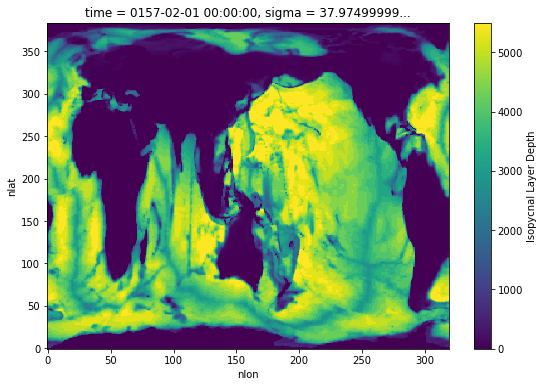

In [13]:
iso_depth.isel(sigma=84).plot(size=6,vmax=5500)

In [14]:
# Isopycnal depth of bottom edge should be same as HT.
htdiff =  iso_depth.isel(sigma=-1) - (ds['HT']/100.).assign_attrs({'units':'m'})
print("Max difference from true HT = {}m".format(abs(htdiff).max().values))

Max difference from true HT = 1.2270752449694555e-05m


#### 3. Compute Isopycnal Layer Horizontal Volume Flux

In [15]:
# Grid-oriented Volume FLuxes:
u_e = ds['UVEL']
v_e = ds['VVEL']
u_e = u_e.where(u_e<1.e30).fillna(0.)
v_e = v_e.where(v_e<1.e30).fillna(0.)
u_e = (u_e*ds['DYU']*ds['dz']/1.e6).assign_attrs({'units':'m^3/s'})
v_e = (v_e*ds['DXU']*ds['dz']/1.e6).assign_attrs({'units':'m^3/s'})

In [16]:
# Volume fluxes in density-space. Vertical sum is density-space should reproduce vertical sum in depth-space.
iso_uflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=u_e,dim=['z_t'],density=False)
iso_uflux = iso_uflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})
iso_vflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=v_e,dim=['z_t'],density=False)
iso_vflux = iso_vflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

ufluxdiff = iso_uflux.sum('sigma') - u_e.sum('z_t')
print("Max difference from true Uflux = {}".format(abs(ufluxdiff).max().values))
vfluxdiff = iso_vflux.sum('sigma') - v_e.sum('z_t')
print("Max difference from true Vflux = {}".format(abs(vfluxdiff).max().values))

Max difference from true Uflux = 1367813.3765927013
Max difference from true Vflux = 456888.7641561439


Need to investigate these differences, which appear to be associated with overflows. The difference plot below shows zero almost everywhere except near Nordic Seas overflow points.

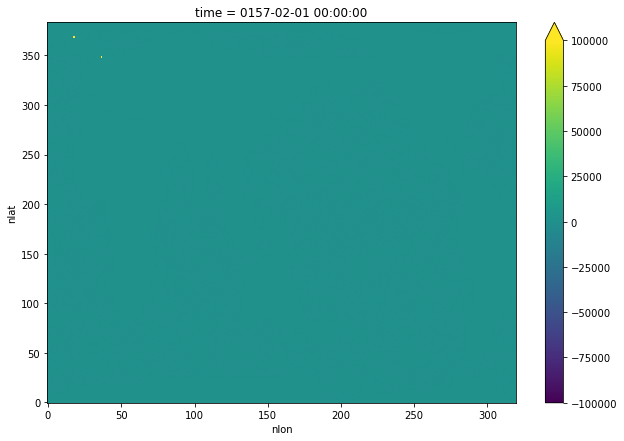

In [17]:
ufluxdiff.plot(size=7,vmin=-1.e5,vmax=1.e5)

#### 4. Compute Vertical Volume Flux using model divergence operator

In [18]:
wflux = popmoc.pop_isowflux(iso_uflux,iso_vflux,'sigma',sigma_edge)

#### 5. Compute Zonal Sums of Vertical Volume Flux in latitude strips

In [19]:
# Load predefined 1-degree target latitude grid:
lat_mid,lat_edge = popmoc.latitude_grid_1deg()

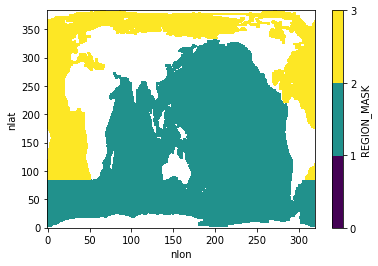

In [21]:
## Define MOC region mask with legend:
rmask = ds.REGION_MASK
rmaskmoc = rmask.where(rmask>0)
rmaskmoc = xr.where((rmask>0),1,rmaskmoc)
rmaskmoc = xr.where((rmask>=6) & (rmask<=11),2,rmaskmoc)
rmaskmoc.plot(levels=[0,1,2,3]);
rmaskmoc.attrs['legend'] = {0:"Global",1:"IndoPac+SO",2:"Atlantic"}

In [22]:
tarea = ds['TAREA']
tlat = ds['TLAT']
wflux_zonsum = popmoc.mesh_zonalavg(wflux,tarea,tlat,rmaskmoc,rmaskmoc.legend,lat_edge,sum=True)

#### 6. Compute cumulative meridional integral of zonally-summed wflux

A southward cumulative integral from 90N avoids issues associated with southern boundary of Atlantic region.

In [24]:
moc = -wflux_zonsum.sel(lat=slice(None,None,-1)).cumsum('lat').sel(lat=slice(None,None,-1))
moc = (moc/1.e6).assign_attrs({'units':'Sv'})   
moc.name = 'MOC'


In [25]:
moc

<xarray.DataArray 'MOC' (region: 3, time: 1, sigma: 86, lat: 180)>
array([[[[-8.04197953e-15, -8.04197953e-15, -8.04197953e-15, ...,
           3.48784660e-03,  1.55869835e-03,  4.73034375e-04],
         [-7.80914888e-15, -7.80914888e-15, -7.80914888e-15, ...,
           3.48784660e-03,  1.55869835e-03,  4.73034375e-04],
         [-8.04197953e-15, -8.04197953e-15, -8.04197953e-15, ...,
           3.48784660e-03,  1.55869835e-03,  4.73034375e-04],
         ...,
         [ 1.63709046e-16,  1.63709046e-16,  1.63709046e-16, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-1.85536919e-16, -1.85536919e-16, -1.85536919e-16, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-1.09139364e-17, -1.09139364e-17, -1.09139364e-17, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]]],


       [[[-1.82304199e-01, -1.82304199e-01, -1.82304199e-01, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-1.82304199e-01, -1.82304199e-01, -1.82304199e-01, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-1.82304199e-01, -1.82304199e-01, -1.82304199e-01, ...,
...
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-1.09139364e-17, -1.09139364e-17, -1.09139364e-17, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-1.09139364e-17, -1.09139364e-17, -1.09139364e-17, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]]],


       [[[ 1.82304199e-01,  1.82304199e-01,  1.82304199e-01, ...,
           3.48784660e-03,  1.55869835e-03,  4.73034375e-04],
         [ 1.82304199e-01,  1.82304199e-01,  1.82304199e-01, ...,
           3.48784660e-03,  1.55869835e-03,  4.73034375e-04],
         [ 1.82304199e-01,  1.82304199e-01,  1.82304199e-01, ...,
           3.48784660e-03,  1.55869835e-03,  4.73034375e-04],
         ...,
         [ 1.74622983e-16,  1.74622983e-16,  1.74622983e-16, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-1.74622983e-16, -1.74622983e-16, -1.74622983e-16, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]]]])
Coordinates:
  * time     (time) object 0157-02-01 00:00:00
  * sigma    (sigma) float64 0.0 28.1 28.3 28.5 28.7 ... 37.82 37.87 37.92 37.97
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * region   (region) <U10 'Global' 'IndoPac+SO' 'Atlantic'
Attributes:
    units:    Sv

(38.0, 29.0)

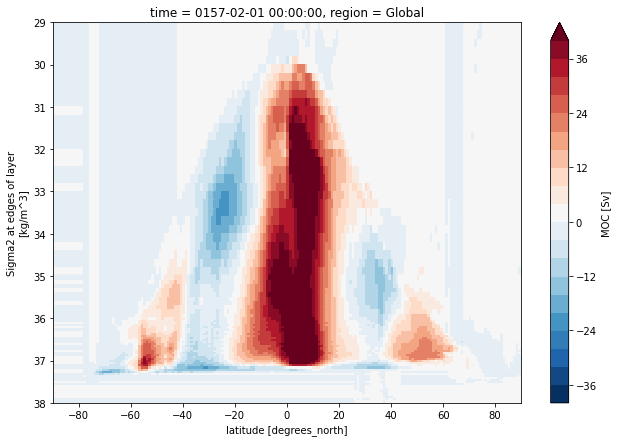

In [26]:
moc.isel(region=0).plot(size=7,vmax=40,levels=21)
plt.ylim([38,29])

(38.0, 29.0)

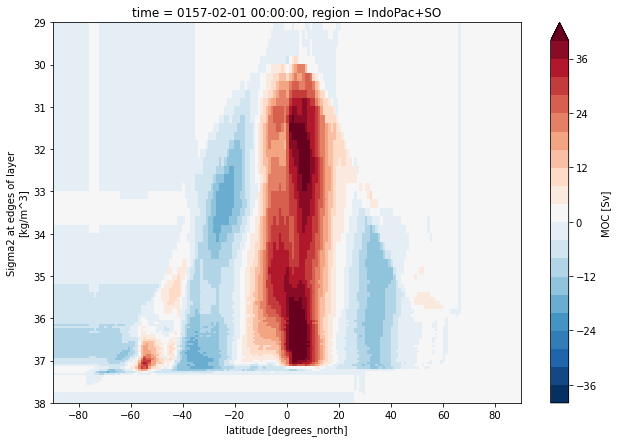

In [27]:
moc.isel(region=1).plot(size=7,vmax=40,levels=21)
plt.ylim([38,29])

(38.0, 29.0)

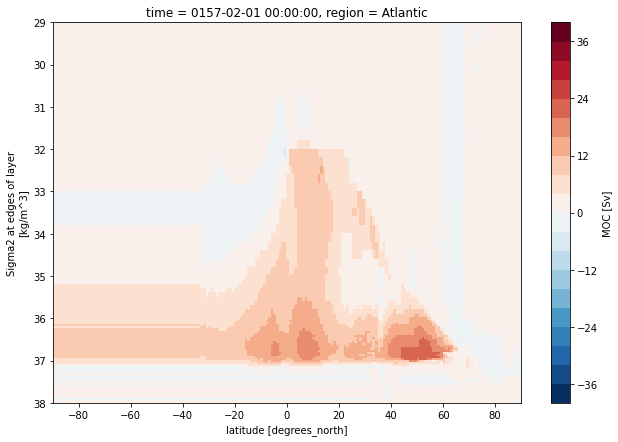

In [28]:
moc.isel(region=2).plot(size=7,vmax=40,levels=21)
plt.ylim([38,29])

(38.0, 29.0)

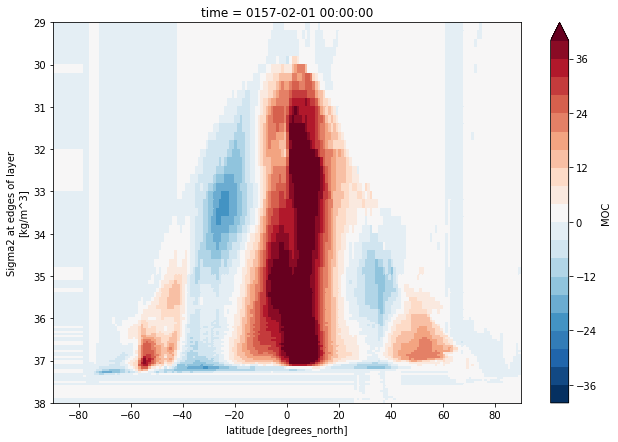

In [29]:
moc.isel(region=[1,2]).sum('region').plot(size=7,vmax=40,levels=21)
plt.ylim([38,29])